# Load Trained SGNS Model

In [1]:
# Import relevant modules
% matplotlib notebook

import sys
sys.path.append("../")

from Models.SGNS import SGNSClassifier, SGNSModel
from Preprocessing.FullContextProcessor import FullContextProcessor

import numpy as np
import pandas as pd
import torch
import pickle

In [2]:
# Recreate the mappings between country-pairs and words with their respective indices
fcp = FullContextProcessor(data_fpath="../Data/ABC-News/abcnews-sgns-processed.txt", sep="\t")
fcp.appendDf(data_fpath="../Data/Times-of-India/india-sgns-processed.txt", sep="\t")

# Filter to c1-c2 pairs that have occured at least [occurance_thresh] times
cpair_counts = fcp.df.loc[fcp.df["pos"]==1, :].groupby("c1-c2")["pos"].count()
valid_cpairs = cpair_counts[cpair_counts >= 200]
fcp.df = fcp.df.loc[fcp.df["c1-c2"].isin(valid_cpairs.keys()), :]

# Create mappings
fcp.createTwoWayMap(colname="c1-c2")
fcp.createTwoWayMap(colname="word")
fcp.convertColToIdx("c1-c2")
fcp.convertColToIdx("word")

# Load model
model = SGNSModel(embedding_dim=5,
                   c_vocab_len = len(fcp.df["c1-c2"].unique()), 
                   w_vocab_len = len(fcp.df["word"].unique()),)
model.load_state_dict(torch.load("sgns-5.pt"))

In [3]:
# Extract the emebddings into numpy arrays
c_embeds = model.c_embeds.weight.detach().numpy()
w_embeds = model.w_embeds.weight.detach().numpy()

# Tensorflow projection

In [4]:
# Write vectors out for tensorflow projector
np.savetxt(fname="c_embeds.txt",
           X=c_embeds,
           fmt="%.8f",
           delimiter="\t",)

with open("c1-c2_labels.txt", "w") as f:
    for idx, c in fcp.twoway_maps["c1-c2"][1].items():
        f.write(c + "\n")

# Country Pair Top Words

In [17]:
w_embeds.shape

(21625, 5)

In [34]:
cpair = "IRQ-USA"
word_dot = np.dot(w_embeds, c_embeds[fcp.twoway_maps["c1-c2"][0][cpair], :])
top_words = np.argsort(word_dot) # sorts low to high
for w_idx in top_words[-50:]:
    print(fcp.twoway_maps["word"][1][w_idx])

occupy
commiting
borrowed
accelerator
ijaz
sofball
wnning
fica
mitt
cag
misunderstanding
expresidents
800m
wizard
bakri
decjan
humpbacks
johnes
gypsies
trashing
hugues
grumble
importation
regretful
surajpur
invalid
gore
kuwaits
seedings
mediocre
etrade
yanukovych
rosales
sta1
defectors
diary
koothu
quashes
guccifer
houthis
anbar
qala
ann
savdhan
snowtown
lashing
isde
interrupte
implicitly
governm


# PCA On Country Embeddings

In [8]:
# Import PCA, standardizer, and plotting capabilities
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [9]:
# Scale data so each dim is mean = 0 std = 1
scaler = StandardScaler()
c_scaled = scaler.fit_transform(X=c_embeds)

# Apply PCA to scaled data
pca = PCA(n_components=2, svd_solver="full")
c_reduced = pca.fit_transform(X=c_scaled)

<IPython.core.display.Javascript object>


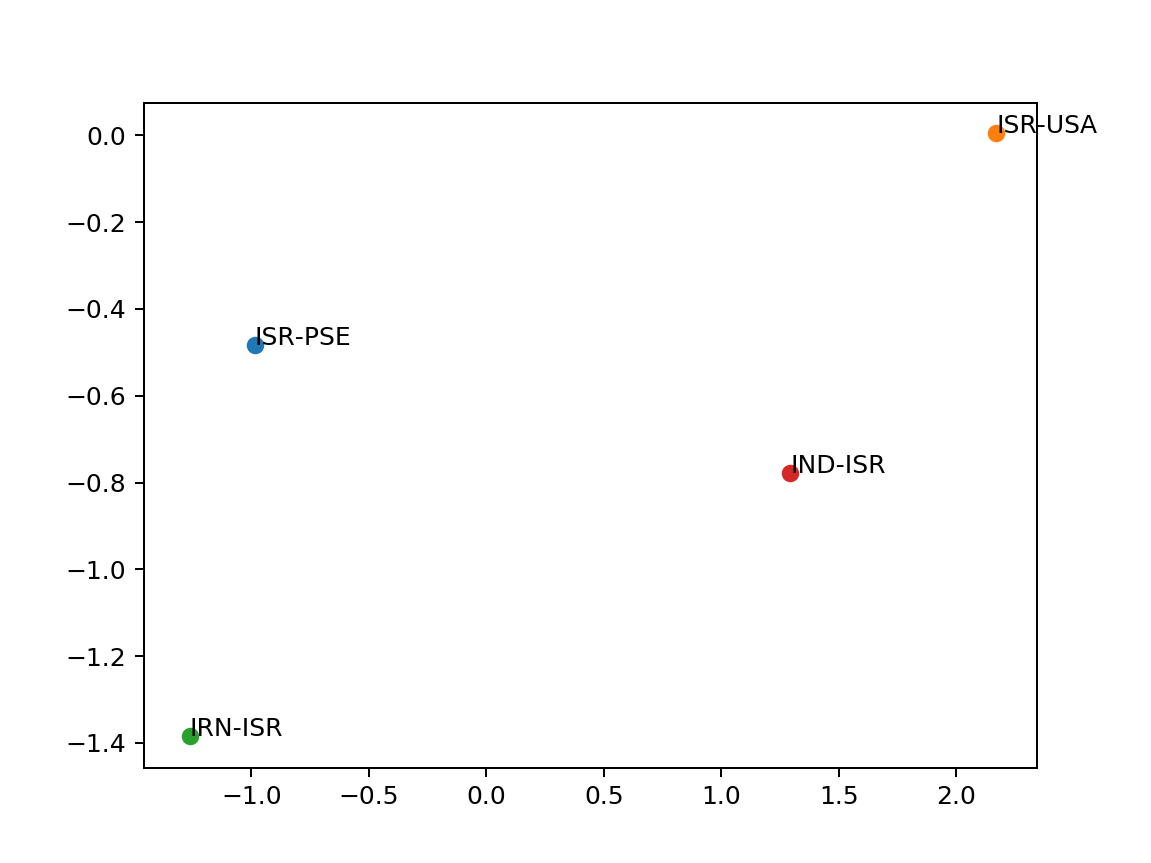

In [12]:
# Plot the projection
country = "ISR"
fig, ax = plt.subplots()
# ax.scatter(x=c_reduced[:, 0], y=c_reduced[:, 1])
for idx in range(c_reduced.shape[0]):
    label = fcp.twoway_maps["c1-c2"][1][idx]
    c1, c2 = label.split("-")
    if c1 == country or c2 == country:
        ax.scatter(x=c_reduced[idx, 0], y=c_reduced[idx, 1])
        ax.annotate(label, (c_reduced[idx, 0], c_reduced[idx, 1]))

## Distribution of country pair datums

In [ ]:
# Get the non-neg samples and group for counting
df = fcp.df.loc[fcp.df["pos"] == 1, :]
c_counts = df.groupby("c1-c2")["pos"].count().sort_values(ascending=False)
c_counts.hist(cumulative=True, density=1.0, bins=100)

In [ ]:
# Top pairs
[fcp.twoway_maps["c1-c2"][1][idx] for idx in c_counts.keys().values.tolist()]

In [ ]:
# Top country mentions
c_counts = df.loc[:, ["c1", "c2"]].stack().value_counts()
print("# unique countries: {}".format(c_counts.shape[0]))
print(c_counts[:60])

In [ ]:
mentions = 50
print("# countries above {} mentions".format(mentions))
(c_counts >= mentions).sum()

In [ ]:
# Find country pairs that had minimum counts and other filters
count_thresh = 50
filter_cpairs = np.sort(c_counts[c_counts >= count_thresh].keys().values) # sort for labelling
c_filtered = c_embeds[filter_cpairs, :]
c_labels = [fcp.twoway_maps["c1-c2"][1][idx] for idx in filter_cpairs]

# Scale data so each dim is mean = 0 std = 1
scaler = StandardScaler()
c_scaled = scaler.fit_transform(X=c_filtered)

# Apply PCA to scaled data
pca = PCA(n_components=2, svd_solver="full")
c_reduced = pca.fit_transform(X=c_scaled)

In [ ]:
# Plot the projection
country = "USA"
fig, ax = plt.subplots()
ax.scatter(x=c_reduced[:, 0], y=c_reduced[:, 1])
for idx, label in enumerate(c_labels):
    c1, c2 = label.split("-")
    if c1 == country or c2 == country:
        ax.annotate(label, (c_reduced[idx, 0], c_reduced[idx, 1]))

In [ ]:
# Write vectors out for tensorflow projector
np.savetxt(fname="c_embeds.txt",
           X=c_filtered,
           fmt="%.8f",
           delimiter="\t",)

with open("c1-c2.txt", "w") as f:
    for idx in filter_cpairs:
        f.write(fcp.twoway_maps["c1-c2"][1][idx] + "\n")

# Most influential dims?

# Top Words of Context Dimensions Embeddings

In [5]:
w_sorted = np.argsort(w_embeds, axis=0) # sorts low to high

In [6]:
top_num = 5
for dim in range(w_sorted.shape[1]):
    print("DIM {}".format(dim))
    print("*"*80)
    print("Highest 5 words")
    for i in range(top_num):
        print("{}".format(fcp.twoway_maps["word"][1][w_sorted[-i-1, dim]]))
    print()
    print("Lowest 5 words")
    for i in range(top_num):
        print("{}".format(fcp.twoway_maps["word"][1][w_sorted[i, dim]]))

DIM 0
********************************************************************************
Highest 5 words
diminishing
trekker
trash
skittles
boosted

Lowest 5 words
indulges
wounded
sakai
filmmaker
ramon
DIM 1
********************************************************************************
Highest 5 words
houthis
interrupte
snowtown
ann
implicitly

Lowest 5 words
ito
raunak
hafooz
libyas
bursts
DIM 2
********************************************************************************
Highest 5 words
flour
nadu
beaches
beckham
blankets

Lowest 5 words
belanger
afford
4nation
nationhood
survived
DIM 3
********************************************************************************
Highest 5 words
regularise
unimpressed
mobile
tigris
transition

Lowest 5 words
rasing
airport
slaughter
flock
ruins
DIM 4
********************************************************************************
Highest 5 words
diversify
immigrating
ayala
delaware
wiki

Lowest 5 words
convinced
mallikarjun
waived
everyone
bri